# Landcover DFD

Logan Gall, gall0487

Attributions/Assistance:
Laure Briol,
Gregory Kohler,
ESRI Arcpy documentation,
ChatGPT,
LucidChart

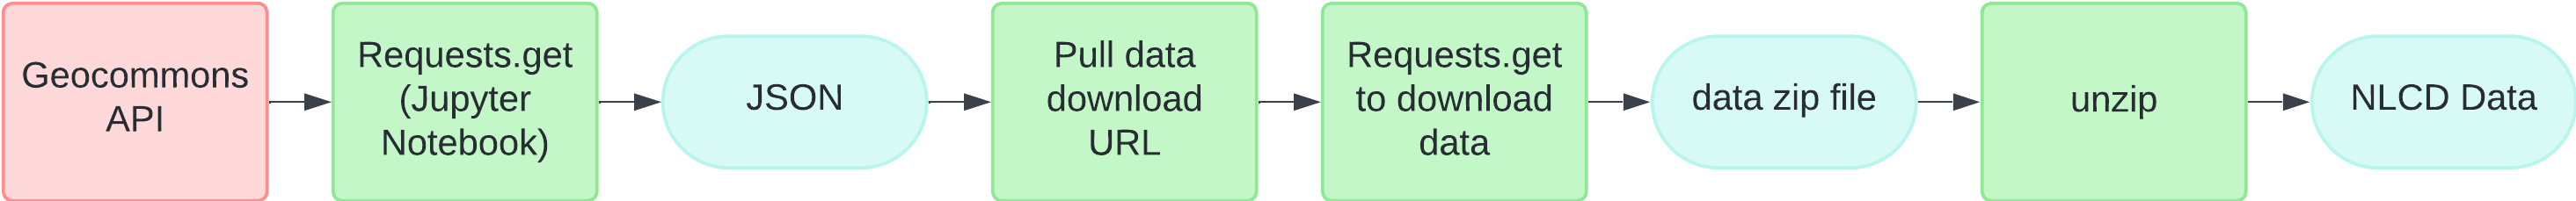

In [1]:
#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import locale
locale.setlocale(locale.LC_ALL, '')

import requests
import arcpy
import zipfile
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import json

In [2]:
def fetch_and_extract_data(json_url, resource_index, folder_name, zip_name):
    """
    Fetches data from a specified API URL, downloads, and extracts the ZIP file.
    """
    # Perform the GET request to fetch the JSON data from the API
    response = requests.get(json_url)
    if response.status_code == 200:
        #pull json data
        json_data = response.json()
        #Extract download link from resources tab
        data_url = json_data['result']['resources'][resource_index]['url']
        print(f"Target URL: {data_url}")
        
        # Proceed to download and extract the ZIP file
        current_directory = os.getcwd()
        zip_path = os.path.join(current_directory, zip_name)
        folder_path = os.path.join(current_directory, folder_name)
        
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)
        
        #Download data using url given from API
        with requests.get(data_url, stream=True) as response:
            with open(zip_path, 'wb') as file:
                shutil.copyfileobj(response.raw, file)
        
        #Extract downloaded zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
        return folder_path
    else:
        print(f"Failed to fetch JSON data. Status code: {response.status_code}")
        return None

# Set the working directory to the ArcGIS Project directory and configure the environment
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
arcpy.env.workspace = os.path.join(file_path, 'MN_Geo_Data')

# Process for MN_Geo_Data
mn_geo_folder = fetch_and_extract_data('https://gisdata.mn.gov/api/3/action/package_show?id=biota-landcover-nlcd-mn-2019', 2, "MN_Geo_Data", "MN_data.zip")
if mn_geo_folder:
    #Add data to map
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    map_obj = aprx.activeMap
    map_obj.addDataFromPath(os.path.join(mn_geo_folder, r'NLCD_2019_Land_Cover.tif'))

# Process for MN_Shape_Data
mn_shape_folder = fetch_and_extract_data('https://gisdata.mn.gov/api/3/action/package_show?id=bdry-state-of-minnesota', 1, "MN_Shape_Data", "MN_shape_data.zip")
if mn_shape_folder:
    #Add data to map
    aprx = arcpy.mp.ArcGISProject("CURRENT")
    map_obj = aprx.activeMap
    map_obj.addDataFromPath(os.path.join(mn_shape_folder, r'Minnesota State Boundary.lyr'))

Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_nlcd_mn_2019/tif_biota_landcover_nlcd_mn_2019.zip
Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/bdry_state_of_minnesota/fgdb_bdry_state_of_minnesota.zip


## QAQC

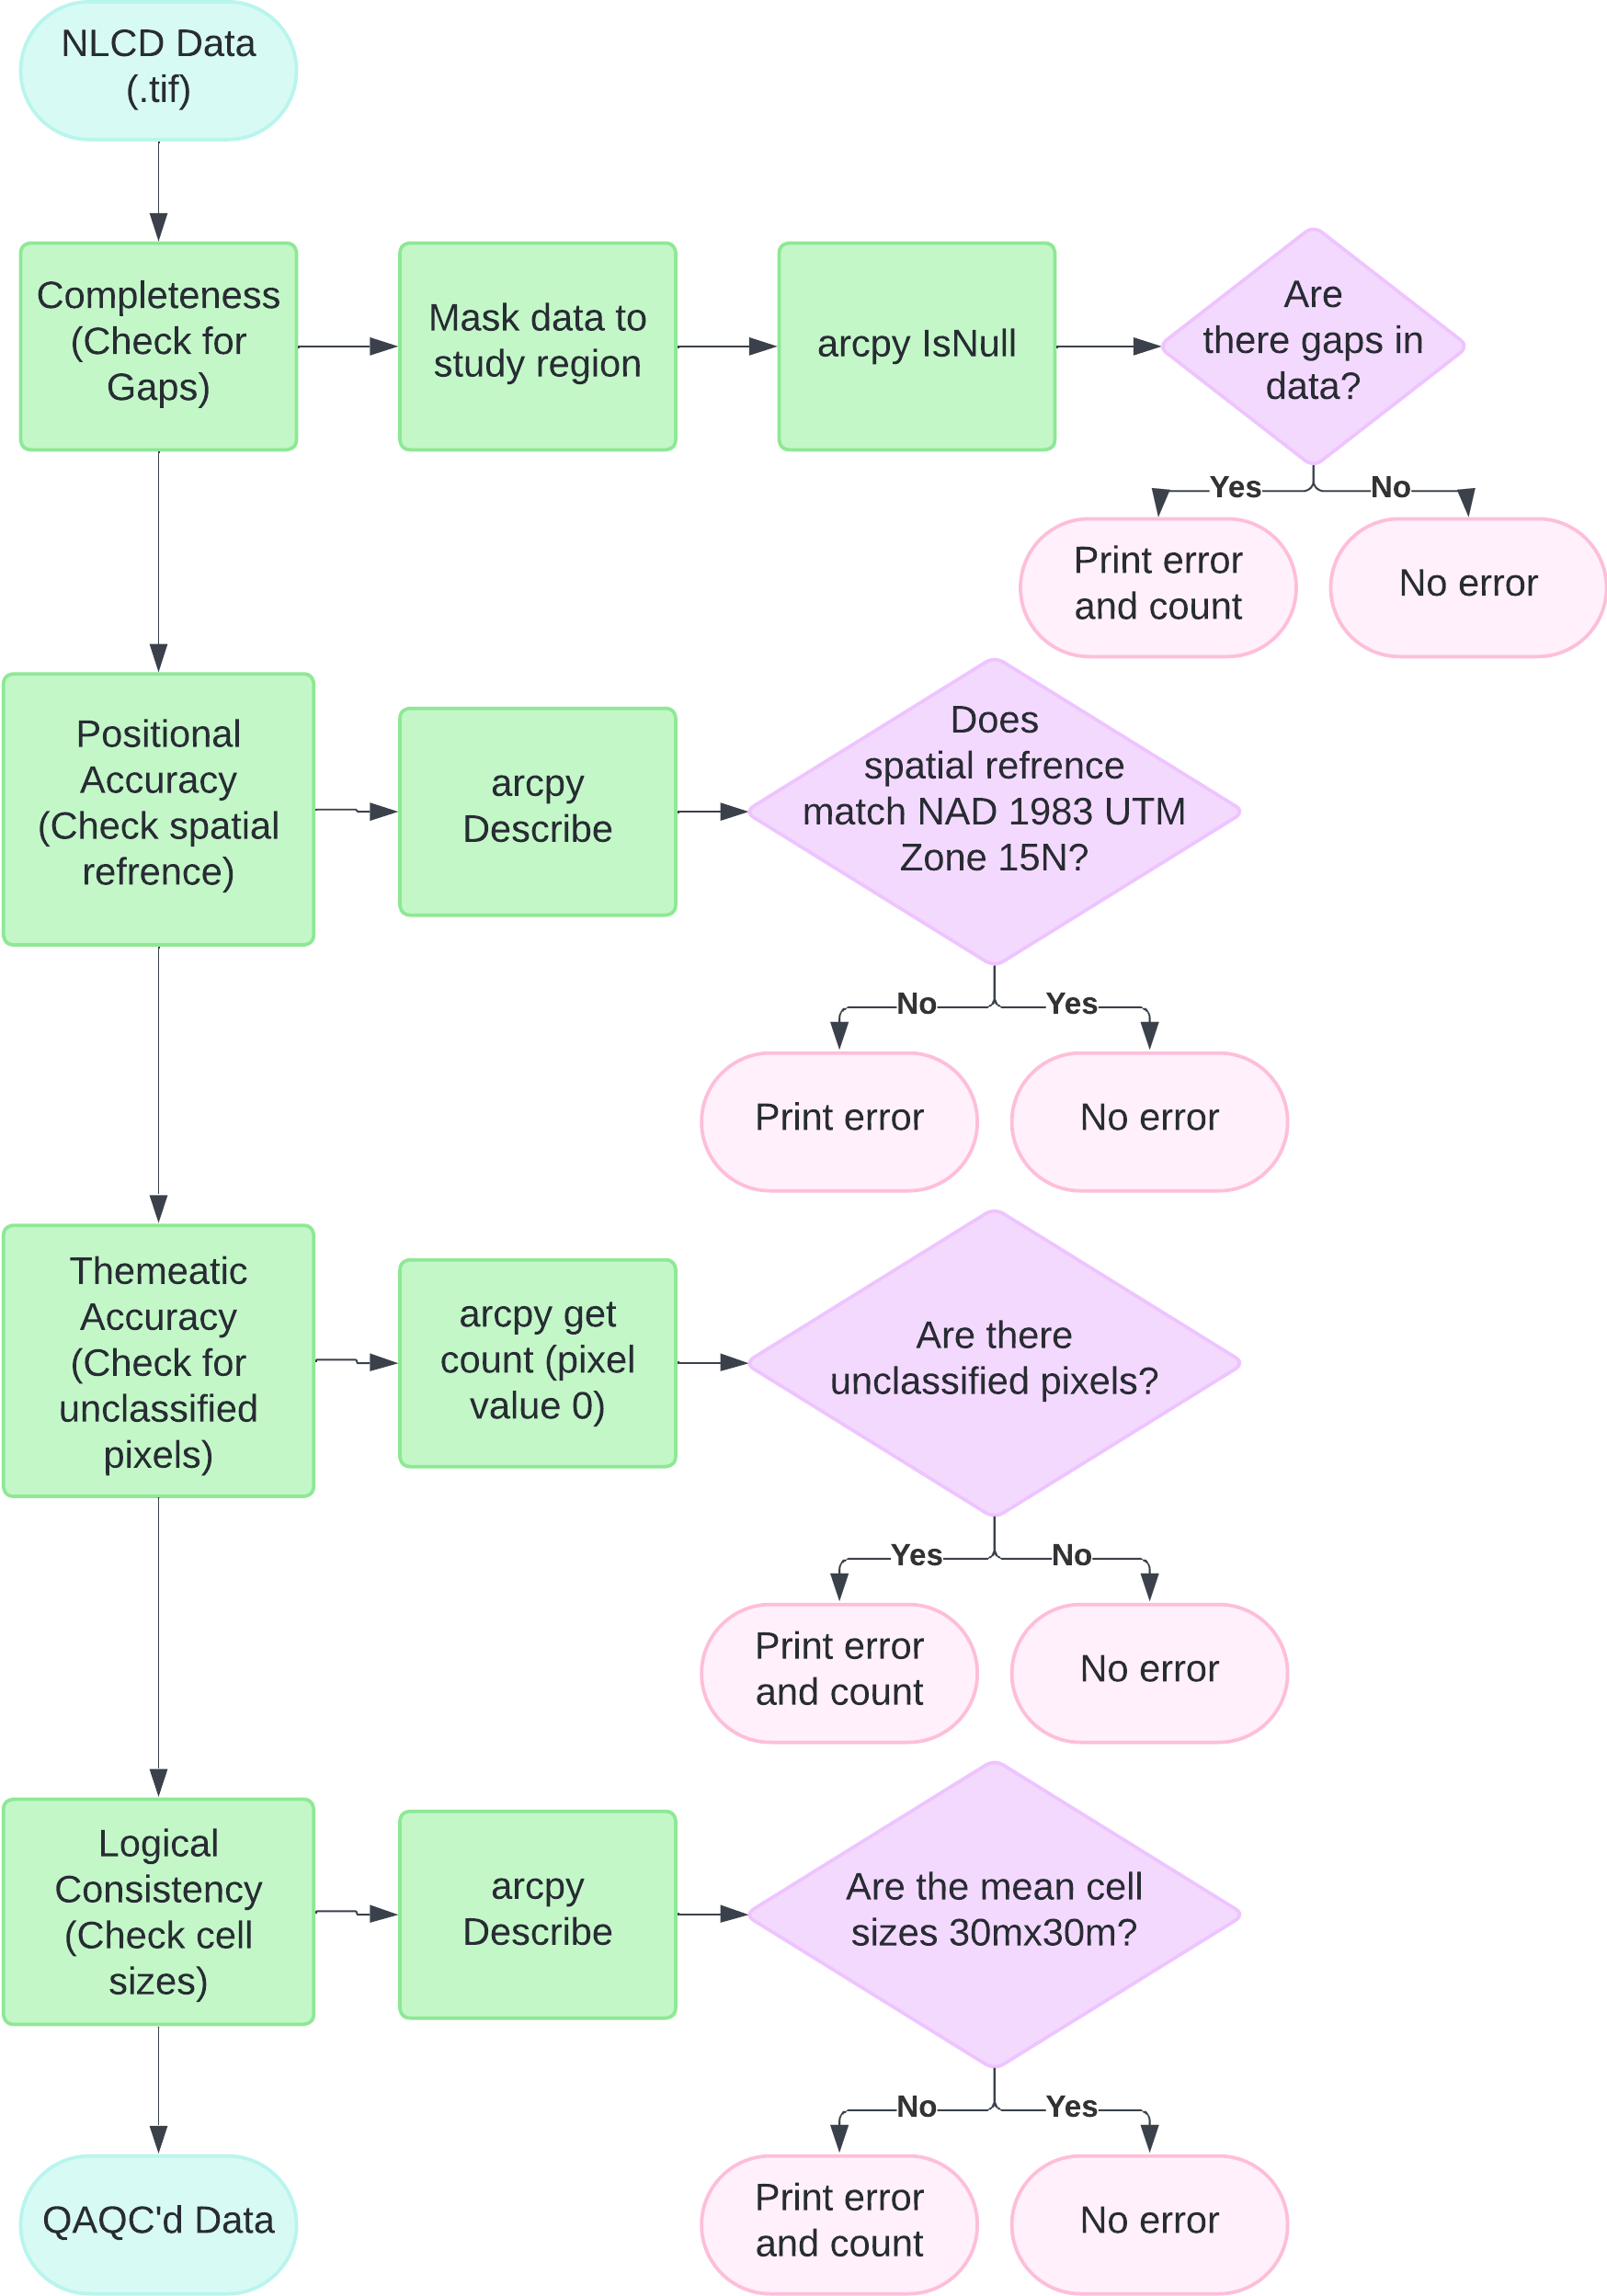

In [7]:
#File paths for data
base_folder_path = "..\\MN_Shape_Data"
boundary_feature_path = os.path.join(base_folder_path, "bdry_state_of_minnesota.gdb", "state_of_minnesota")
landcover_tif_path = "NLCD_2019_Land_Cover.tif"

#turn state boundary to raster
boundary_to_raster_output = "state_boundary_raster.tif"
arcpy.PolygonToRaster_conversion(
    in_features=boundary_feature_path,
    value_field="OBJECTID",
    out_rasterdataset=boundary_to_raster_output,
    cell_assignment="CELL_CENTER",
    cellsize=landcover_tif_path
)

#mask the shape data from null to 1
boundary_raster_with_nodata = arcpy.ia.SetNull(boundary_to_raster_output, 1, "VALUE = 1")

#masking data so we only look at data within Minnesota
arcpy.env.mask = boundary_raster_with_nodata
masked_landcover_output = "masked_landcover.tif"
arcpy.management.CopyRaster(landcover_tif_path, masked_landcover_output)

#check for gaps in landcover data
analysis = arcpy.sa.IsNull(masked_landcover_output)

#count the number of gaps in the landcover data
gap_counter = arcpy.GetCount_management(analysis)

value = int(gap_counter.getOutput(0))

# Display results based on gap analysis
if value > 1000:
    print(f"{gap_counter} gaps found in the landcover data.")
else:
    print("Landcover data is complete with no gaps detected.")


1 gaps found in the landcover data.


In [11]:
#path to tif
tif_path = "NLCD_2019_Land_Cover.tif"
#What we excpect our data spatial refrence to be
expected_ref="NAD_1983_UTM_Zone_15N"

# Obtain spatial reference details of the TIFF file
spatial_reference = arcpy.Describe(tif_path).spatialReference

# Evaluate and print the result based on the spatial reference check
if spatial_reference.name == expected_ref:
    print(f"Spatial Reference Check: Passed. ({spatial_reference.name})")
else:
    print(f"Spatial Reference Check: Failed. Found: {spatial_reference.name}, Expected: {expected_ref}")


Spatial Reference Check: Passed. (NAD_1983_UTM_Zone_15N)


In [17]:
raster_path = "NLCD_2019_Land_Cover.tif"

# Load the raster dataset
nlcd_raster = arcpy.Raster(raster_path)

#count the number of pixels with value 0 (unclassified items)
unclassified_pixels_count = int(arcpy.GetCount_management(raster_path).getOutput(0))

# Print and evaluate the count against the threshold
print(f"Unclassified pixels count: {unclassified_pixels_count}")
if unclassified_pixels_count < 1000:
    print("Thematic Accuracy: Acceptable.")
else:
    print("Thematic Accuracy: Issue detected, review required.")

# Example usage

Unclassified pixels count: 16
Thematic Accuracy: Acceptable.


In [15]:
#logical Consistency (data structure)-- Landsat
#path to your NLCD raster dataset
nlcd_file = "NLCD_2019_Land_Cover.tif"

#create a Describe object to get properties of the dataset
desc = arcpy.Describe(nlcd_file)

#get the cell size
cell_width = desc.meanCellWidth
cell_height = desc.meanCellHeight

#print the cell size
print("Cell Size - Width: {} meters, Height: {} meters".format(cell_width, cell_height))

#check if the cell size is 30 by 30 meters
if cell_width == 30 and cell_height == 30:
    print("Data is good")
else:
    print("Data is bad")

Cell Size - Width: 30.0 meters, Height: 30.0 meters
Data is good
